# --- 1. INSTALACIÓN Y CONFIGURACIÓN ---



In [1]:

!pip install ortools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
import copy
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Configurar dispositivo (GPU si está disponible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {DEVICE}")

# Crear carpetas para organizar archivos
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.

✅ Usando dispositivo: cuda


# --- 2. CLASES AUXILIARES Y SOLVER ---

In [2]:
class TSP_Instance:
    def __init__(self, city_locations):
        self.city_locations = city_locations
        self.num_cities = len(city_locations)
        # Matriz de distancias Euclidianas
        diff = city_locations[:, np.newaxis, :] - city_locations[np.newaxis, :, :]
        self.distance_matrix = np.sqrt(np.sum(diff ** 2, axis=-1))

class TSP_State:
    def __init__(self, instance):
        self.instance = instance
        self.num_cities = instance.num_cities
        self.visited = [False] * self.num_cities
        self.current_city = 0
        self.tour = [0] # Siempre empezamos en 0
        self.visited[0] = True
        self.cost = 0.0

    def visit_city(self, city_idx):
        if not self.visited[city_idx]:
            dist = self.instance.distance_matrix[self.current_city][city_idx]
            self.cost += dist
            self.current_city = city_idx
            self.tour.append(city_idx)
            self.visited[city_idx] = True

    def is_finished(self):
        return all(self.visited)

    def plot(self):
        x = [self.instance.city_locations[i][0] for i in self.tour]
        y = [self.instance.city_locations[i][1] for i in self.tour]
        if self.is_finished(): # Cerrar el ciclo
            x.append(x[0])
            y.append(y[0])
        plt.figure(figsize=(5, 5))
        plt.scatter(x, y, c='red')
        plt.plot(x, y, c='blue')
        plt.title(f"Costo: {self.cost:.4f}")
        plt.show()

def solve_ortools(instance):
    # Configurar datos para OR-Tools
    scale = 10000
    dist_matrix = (instance.distance_matrix * scale).astype(int).tolist()

    manager = pywrapcp.RoutingIndexManager(instance.num_cities, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return dist_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    # Extraer tour
    route = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
    return route # Retorna lista de índices

# --- 3. GENERACIÓN DE DATOS ---

In [ ]:
# ==========================================
# EXTENSIÓN DE DATASET EN DRIVE
# ==========================================
import pickle
import os
import numpy as np
import shutil
from google.colab import drive

def extend_dataset_in_drive(extra_samples=10000, num_cities=35, drive_folder="TSP", filename="TSP100_train.pkl"):
    # 1. Montar Drive
    print("🔄 Montando Google Drive...")
    drive.mount('/content/drive')

    drive_path = f"/content/drive/MyDrive/{drive_folder}/{filename}"
    local_path = filename

    # 2. Cargar datos existentes si existen
    X_existing, Visited_existing, Y_existing = [], [], []

    if os.path.exists(drive_path):
        print(f"📂 Archivo encontrado. Cargando datos actuales de {filename}...")
        with open(drive_path, "rb") as f:
            X_existing, Visited_existing, Y_existing = pickle.load(f)

        # Convertir a listas para poder hacer .append fácilmente
        X_existing = list(X_existing)
        Visited_existing = list(Visited_existing)
        Y_existing = list(Y_existing)
        print(f"   Ejemplos actuales: {len(X_existing)}")
    else:
        print("⚠️ No se encontró el archivo previo. Se creará uno nuevo.")

    # 3. Generar nuevos datos (Lógica igual a tu Bloque 3)
    print(f"🚀 Generando {extra_samples} nuevas instancias...")

    for i in range(extra_samples):
        locs = np.random.rand(num_cities, 2)
        instance = TSP_Instance(locs)
        optimal_tour = solve_ortools(instance)

        current_state_tour = [0]

        # Simulamos pasos del tour
        for target_city in optimal_tour[1:]:
            X_existing.append(locs)

            vis_pad = np.array(current_state_tour)
            vis_pad = np.pad(vis_pad, (0, num_cities - len(vis_pad)), 'constant', constant_values=-1)
            Visited_existing.append(vis_pad)

            y_onehot = np.zeros(num_cities)
            y_onehot[target_city] = 1
            Y_existing.append(y_onehot)

            current_state_tour.append(target_city)

        if (i + 1) % 1000 == 0:
            print(f"   ✅ {i + 1}/{extra_samples} mapas procesados...")

    # 4. Guardar archivo actualizado
    print(f"💾 Guardando dataset actualizado (Total: {len(X_existing)} ejemplos)...")
    updated_data = (np.array(X_existing), np.array(Visited_existing), np.array(Y_existing))

    # Guardar localmente primero (por seguridad)
    with open(local_path, "wb") as f:
        pickle.dump(updated_data, f)

    # Mover a Drive reemplazando el viejo
    shutil.copy(local_path, drive_path)

    print(f"✨ ¡Listo! Tu archivo en Drive '{drive_path}' ha sido actualizado.")

# EJECUTAR
extend_dataset_in_drive(extra_samples=10000, num_cities=100)

🔄 Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Archivo encontrado. Cargando datos actuales de TSP100_train.pkl...


# --- 4. ARQUITECTURA DEL MODELO ---

In [3]:
# --- 4. ARQUITECTURA MEJORADA (CNN EMBEDDING + TRANSFORMER) ---

class CNNEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim, k=10):
        super().__init__()
        self.k = k
        # Convolución: Input channels = 4 (coord x,y del centro + coord x,y del vecino)
        # Output channels = embed_dim
        self.conv = nn.Conv1d(in_channels=4, out_channels=embed_dim, kernel_size=1)

    def forward(self, x):
        # x: [Batch, Cities, 2]
        B, N, D = x.shape

        # 1. Calcular distancias para encontrar vecinos (k-NN)
        # Distancia Euclidiana [B, N, N]
        dists = torch.cdist(x, x, p=2)

        # 2. Encontrar los k vecinos más cercanos
        # k + 1 porque el más cercano siempre es uno mismo (distancia 0)
        _, indices = dists.topk(k=self.k + 1, dim=-1, largest=False)
        knn_idx = indices[:, :, 1:] # [B, N, k] (Quitamos el 0)

        # 3. Construir el tensor de vecinos
        batch_idx = torch.arange(B, device=x.device).view(B, 1, 1).expand(B, N, self.k)

        # Vecinos coords: [B, N, k, 2]
        neighbors = x[batch_idx, knn_idx]

        # Nodo central repetido k veces: [B, N, k, 2]
        center = x.unsqueeze(2).expand(-1, -1, self.k, -1)

        # Concatenar: [B, N, k, 4] -> (x_center, y_center, x_neighbor, y_neighbor)
        features = torch.cat([center, neighbors], dim=-1)

        # 4. Preparar para Conv1d
        # Permute para que los canales sean la segunda dimensión: [B*N, 4, k]
        features = features.view(B*N, self.k, 4).permute(0, 2, 1)

        # Conv: [B*N, embed_dim, k]
        out = self.conv(features)

        # Max Pool sobre los k vecinos -> [B*N, embed_dim]
        # Nos quedamos con la característica más fuerte del vecindario
        out = torch.max(out, dim=-1)[0]

        # Reshape final [B, N, embed_dim]
        return out.view(B, N, -1)

class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.hyperparams = kwargs

    def encode(self, x): raise NotImplementedError
    def decode(self, mem, vis): raise NotImplementedError

class TSPTransformer(Transformer):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=4, num_encoder_layers=2,
                 num_glimpses=2, dropout_rate=0.1, dist_bias_scale=1.0, k_neighbors=10):
        super().__init__(input_dim=input_dim, embed_dim=embed_dim, num_heads=num_heads,
                         num_encoder_layers=num_encoder_layers, num_glimpses=num_glimpses,
                         dropout_rate=dropout_rate, dist_bias_scale=dist_bias_scale)

        self.embed_dim = embed_dim
        self.dist_bias_scale = dist_bias_scale
        self.num_glimpses = num_glimpses

        # --- CAMBIO IMPORTANTE: CNN EMBEDDING ---
        # Reemplazamos la capa lineal simple por la CNN
        self.encoder_input_layer = CNNEmbedding(input_dim, embed_dim, k=k_neighbors)
        # ----------------------------------------

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dropout=dropout_rate, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder Components (IGUAL QUE ANTES)
        self.ctx_fusion = nn.Linear(3 * embed_dim, embed_dim)
        self.glimpse_proj = nn.Linear(embed_dim, embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(nn.Linear(embed_dim, 4*embed_dim), nn.ReLU(), nn.Linear(4*embed_dim, embed_dim))
        self.norm2 = nn.LayerNorm(embed_dim)
        self.pointer_proj = nn.Linear(embed_dim, embed_dim, bias=False)

    def encode(self, x_src):
        return self.encoder(self.encoder_input_layer(x_src))

    def decode(self, memory, coords, visited):
        # (Lógica idéntica a tu modelo anterior)
        B, N, _ = memory.shape
        device = memory.device

        visited_mask_pos = (visited != -1)
        visited_city_mask = torch.zeros(B, N, dtype=torch.bool, device=device)
        batch_indices = torch.arange(B, device=device).unsqueeze(1).expand_as(visited)
        valid_visited = visited.clone()
        valid_visited[~visited_mask_pos] = 0
        visited_city_mask[batch_indices[visited_mask_pos], valid_visited[visited_mask_pos].long()] = True

        mask_expanded = visited_city_mask.unsqueeze(-1).float()
        sum_ctx = (memory * mask_expanded).sum(dim=1)
        count_ctx = mask_expanded.sum(dim=1).clamp(min=1)
        context_mean = sum_ctx / count_ctx

        lengths = visited_mask_pos.sum(dim=1) - 1
        last_nodes = visited.gather(1, lengths.unsqueeze(1)).squeeze(1).long()
        start_nodes = visited[:, 0].long()

        batch_idx = torch.arange(B, device=device)
        start_embed = memory[batch_idx, start_nodes]
        last_embed = memory[batch_idx, last_nodes]

        ctx_concat = torch.cat([context_mean, last_embed, start_embed], dim=-1)
        decoder_state = self.ctx_fusion(ctx_concat)

        query = self.glimpse_proj(decoder_state).unsqueeze(1)

        for _ in range(self.num_glimpses):
            attn_out, _ = self.cross_attn(query, memory, memory, key_padding_mask=visited_city_mask)
            query = self.norm1(attn_out + query)
            ff_out = self.ff(query)
            query = self.norm2(ff_out + query)

        attn_out = query.squeeze(1)
        ptr_query = self.pointer_proj(attn_out).unsqueeze(1)
        scores = torch.matmul(ptr_query, memory.transpose(1, 2)).squeeze(1)
        scores = scores / math.sqrt(self.embed_dim)

        last_city_coords = coords[batch_idx, last_nodes]
        dists = torch.norm(coords - last_city_coords.unsqueeze(1), dim=-1)
        scores = scores - (self.dist_bias_scale * dists)
        scores = scores.masked_fill(visited_city_mask, float('-inf'))
        return scores

    def forward(self, x_src, visited):
        memory = self.encode(x_src)
        return self.decode(memory, x_src, visited)

# --- 5. ENTRENAMIENTO ---

In [4]:
#Extra
from google.colab import drive
# --- NUEVA FUNCIÓN DE AUMENTO DE DATOS ---
def augment_dataset_rotation(X, Visited, Y):
    """
    Multiplica el dataset x4 aplicando rotaciones de 90, 180 y 270 grados.
    Asume que X está en el rango [0, 1].
    """
    print(f"✨ Aplicando Data Augmentation (Rotación)... Tamaño original: {len(X)}")

    # 1. Original (0°)
    X_0 = X.clone()

    # 2. Rotación 90°: (x, y) -> (y, 1-x)
    X_90 = X.clone()
    X_90[:, :, 0] = X[:, :, 1]          # Nuevo x = Viejo y
    X_90[:, :, 1] = 1.0 - X[:, :, 0]    # Nuevo y = 1 - Viejo x

    # 3. Rotación 180°: (x, y) -> (1-x, 1-y)
    X_180 = X.clone()
    X_180[:, :, 0] = 1.0 - X[:, :, 0]
    X_180[:, :, 1] = 1.0 - X[:, :, 1]

    # 4. Rotación 270°: (x, y) -> (1-y, x)
    X_270 = X.clone()
    X_270[:, :, 0] = 1.0 - X[:, :, 1]
    X_270[:, :, 1] = X[:, :, 0]

    # Concatenar todos los mapas (x4)
    X_aug = torch.cat([X_0, X_90, X_180, X_270], dim=0)

    # Las etiquetas (Y) y el historial (Visited) NO cambian con la rotación
    # (la ciudad 5 sigue siendo la ciudad 5 aunque cambie de coordenadas)
    # Así que simplemente duplicamos estas matrices 4 veces.
    Visited_aug = Visited.repeat(4, 1)
    Y_aug = Y.repeat(4, 1)

    print(f"✅ Aumento completado. Nuevo tamaño: {len(X_aug)}")
    return X_aug, Visited_aug, Y_aug

def load_data_robust(local_path, drive_path):
    """
    Carga datos soportando .pkl antiguo y .npz nuevo con llaves ['points', 'solutions']
    Transforma las soluciones completas en pasos de entrenamiento (Teacher Forcing).
    """

    # 1. Copiar desde Drive si no está en local
    if not os.path.exists(local_path):
        print(f"📥 Copiando desde Drive ({drive_path})...")
        if os.path.exists(drive_path):
            os.makedirs(os.path.dirname(local_path), exist_ok=True)
            shutil.copy(drive_path, local_path)
        else:
            print(f"❌ ERROR: No existe {drive_path}")
            return None

    print(f"📂 Leyendo dataset: {local_path}")

    try:
        X_final, Visited_final, Y_final = [], [], []

        # --- CASO 1: ARCHIVO .NPZ (NUEVO) ---
        if local_path.endswith('.npz'):
            data = np.load(local_path)
            print(f"   🔑 Llaves detectadas: {data.files}")

            if 'points' in data.files and 'solutions' in data.files:
                raw_X = data['points']      # [Samples, Cities, 2]
                raw_Sol = data['solutions'] # [Samples, Cities] (Indices)

                num_samples = len(raw_X)
                num_cities = raw_X.shape[1]

                print(f"   ⚙️ Descomponiendo {num_samples} rutas en pasos de entrenamiento...")

                # Bucle para convertir rutas completas en pasos individuales
                # (Esto puede tardar un poco, pero es necesario para entrenar)
                for i in range(num_samples):
                    coords = raw_X[i]
                    tour = raw_Sol[i]

                    # El estado inicial siempre es la primera ciudad del tour
                    current_path = [tour[0]]

                    # Recorremos el tour para crear los pares (Estado -> Siguiente Acción)
                    for target_node in tour[1:]:
                        # 1. El Mapa (siempre el mismo)
                        X_final.append(coords)

                        # 2. Historial de visitados (con padding de -1)
                        vis_pad = np.full(num_cities, -1)
                        vis_pad[:len(current_path)] = current_path
                        Visited_final.append(vis_pad)

                        # 3. Target (One-Hot Encoding del siguiente nodo)
                        y_onehot = np.zeros(num_cities)
                        y_onehot[target_node] = 1
                        Y_final.append(y_onehot)

                        # Actualizamos el camino para el siguiente paso
                        current_path.append(target_node)

                # Convertir listas a arrays numpy primero (más rápido)
                X_np = np.array(X_final)
                Visited_np = np.array(Visited_final)
                Y_np = np.array(Y_final)

            else:
                print("❌ ERROR: El .npz no tiene las llaves 'points' y 'solutions'.")
                return None

        # --- CASO 2: ARCHIVO .PKL (ANTIGUO) ---
        else:
            with open(local_path, "rb") as f:
                X_np, Visited_np, Y_np = pickle.load(f)

        # --- CONVERSIÓN A TENSORES ---
        print(f"⚙️ Creando Tensores (Total pasos: {len(X_np)})...")
        X = torch.tensor(X_np, dtype=torch.float32)
        Visited = torch.tensor(Visited_np, dtype=torch.long)
        Y = torch.tensor(Y_np, dtype=torch.float32)

        # Normalización de seguridad [0, 1]
        if X.max() > 1.0:
            X = X / X.max()

        print(f"✅ Dataset listo. Shape X: {X.shape}")
        return TensorDataset(X, Visited, Y)

    except Exception as e:
        print(f"❌ Error crítico cargando datos: {e}")
        # Borrar archivo corrupto local para forzar recarga la próxima vez
        if os.path.exists(local_path): os.remove(local_path)
        return None

In [ ]:
# --- 5. ENTRENAMIENTO (MODELO CNN NUEVO) ---
import shutil
def train_pipeline_cnn(epochs=20, batch_size=256, lr=1e-4):
    print("🔄 Montando Google Drive...")
    drive.mount('/content/drive')

    DRIVE_FOLDER = "/content/drive/MyDrive/TSP"

    # AHORA USAMOS EL ARCHIVO PROCESADO (.pt)
    DRIVE_DATA_FILE = os.path.join(DRIVE_FOLDER, "TSP50_READY.pt")
    DRIVE_MODEL_FILE = os.path.join(DRIVE_FOLDER, "CNN_TSP_Model.pth")

    # 1. CARGA RÁPIDA DE DATOS
    if not os.path.exists(DRIVE_DATA_FILE):
        print(f"❌ No encuentro {DRIVE_DATA_FILE}. Ejecuta el script de pre-procesamiento primero.")
        return None, []

    print(f"🚀 Cargando dataset procesado desde: {DRIVE_DATA_FILE}")
    # Carga directa a RAM (muy rápido)
    data_dict = torch.load(DRIVE_DATA_FILE)

    X = data_dict["X"]
    Visited = data_dict["Visited"]
    Y = data_dict["Y"]

    print(f"✅ Datos cargados. Total pasos de entrenamiento: {len(X)}")

    dataset = TensorDataset(X, Visited, Y)

    # Split
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # MODELO NUEVO (Con K=10 vecinos)
    print("🧠 Inicializando modelo CON CNN EMBEDDING...")
    model = TSPTransformer(input_dim=2, embed_dim=128, num_heads=4,
                           num_encoder_layers=2, k_neighbors=10).to(DEVICE)

    # REANUDACIÓN
    if os.path.exists(DRIVE_MODEL_FILE):
        print(f"🔄 Reanudando modelo CNN desde: {DRIVE_MODEL_FILE}")
        try:
            model.load_state_dict(torch.load(DRIVE_MODEL_FILE, map_location=DEVICE))
            print("✅ Pesos cargados.")
        except Exception as e:
            print(f"⚠️ Error cargando pesos ({e}). Empezando de cero.")
    else:
        print("🆕 Empezando entrenamiento de modelo CNN desde cero.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"🚀 Entrenando {epochs} épocas...")
    loss_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0

        for bx, bvis, by in train_loader:
            bx, bvis, by = bx.to(DEVICE), bvis.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            logits = model(bx, bvis)
            target = by.argmax(dim=1)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (logits.argmax(dim=1) == target).sum().item()
            total_train += target.size(0)

        # Validación
        model.eval()
        val_loss = 0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for bx, bvis, by in val_loader:
                bx, bvis, by = bx.to(DEVICE), bvis.to(DEVICE), by.to(DEVICE)
                logits = model(bx, bvis)
                target = by.argmax(dim=1)
                loss = criterion(logits, target)
                val_loss += loss.item()
                val_correct += (logits.argmax(dim=1) == target).sum().item()
                total_val += target.size(0)

        avg_tr_loss = train_loss / len(train_loader)
        avg_vl_loss = val_loss / len(val_loader)
        acc_train = 100 * train_correct / total_train
        acc_val = 100 * val_correct / total_val

        loss_history.append(avg_vl_loss)
        print(f"Ep {epoch+1}/{epochs} | Tr Loss: {avg_tr_loss:.4f} Acc: {acc_train:.1f}% | Val Loss: {avg_vl_loss:.4f} Acc: {acc_val:.1f}%")

        # Guardado en Drive
        if (epoch + 1) % 3 == 0:
            ckpt_name = f"cnn_tsp_transformer_ep{epoch+1}.pth"
            ckpt_drive = os.path.join(DRIVE_FOLDER, ckpt_name)
            torch.save(model.state_dict(), ckpt_name)
            shutil.copy(ckpt_name, ckpt_drive)
            print(f"   💾 Checkpoint guardado: {ckpt_drive}")

        # Guardar siempre el último estado
        torch.save(model.state_dict(), "temp_final_cnn.pth")
        try:
            shutil.copy("temp_final_cnn.pth", DRIVE_MODEL_FILE)
        except: pass

    print("✅ Entrenamiento finalizado.")
    return model, loss_history

# ¡ENTRENAR!
trained_model, history = train_pipeline_cnn(epochs=20)

🔄 Montando Google Drive...
Mounted at /content/drive
🚀 Cargando dataset procesado desde: /content/drive/MyDrive/TSP/TSP50_READY.pt
✅ Datos cargados. Total pasos de entrenamiento: 4900000
🧠 Inicializando modelo CON CNN EMBEDDING...
🔄 Reanudando modelo CNN desde: /content/drive/MyDrive/TSP/CNN_TSP_Model.pth
✅ Pesos cargados.
🚀 Entrenando 20 épocas...
Ep 1/20 | Tr Loss: 0.2892 Acc: 89.4% | Val Loss: 0.2683 Acc: 90.3%
Ep 2/20 | Tr Loss: 0.2835 Acc: 89.6% | Val Loss: 0.2659 Acc: 90.4%
Ep 3/20 | Tr Loss: 0.2786 Acc: 89.7% | Val Loss: 0.2621 Acc: 90.5%
   💾 Checkpoint guardado: /content/drive/MyDrive/TSP/cnn_tsp_transformer_ep3.pth
Ep 4/20 | Tr Loss: 0.2745 Acc: 89.8% | Val Loss: 0.2555 Acc: 90.7%
Ep 5/20 | Tr Loss: 0.2710 Acc: 89.9% | Val Loss: 0.2561 Acc: 90.7%
Ep 6/20 | Tr Loss: 0.2677 Acc: 90.0% | Val Loss: 0.2499 Acc: 90.9%
   💾 Checkpoint guardado: /content/drive/MyDrive/TSP/cnn_tsp_transformer_ep6.pth
Ep 7/20 | Tr Loss: 0.2649 Acc: 90.1% | Val Loss: 0.2479 Acc: 91.0%
Ep 8/20 | Tr Loss:

# --- 6. VALIDACIÓN (Inferencia Greedy) ---

#GUARDAR BENCHMARCK

In [ ]:
# ==========================================
# BLOQUE: GENERACIÓN DE DATASET DE PRUEBA
# ==========================================
print("🎲 Generando mapas de prueba y soluciones OR-Tools...")

# Configuración: puedes ajustar la dificultad aquí
BENCHMARK_CONFIGS = [
    {"name": "EASY_20",   "n": 20,  "s": 10000},
    {"name": "MEDIUM_50", "n": 50,  "s": 5000},
    {"name": "HARD_100",  "n": 100, "s": 2500}
]

BENCHMARK_DATA = {}

for cfg in BENCHMARK_CONFIGS:
    print(f"🔹 Procesando {cfg['name']}...")
    X_np, Y_np = generate_batch_and_solve(cfg['n'], cfg['s'])

    # Pasamos a tensor una sola vez para ahorrar tiempo después
    BENCHMARK_DATA[cfg['name']] = {
        "X": torch.tensor(X_np, dtype=torch.float32).to(DEVICE),
        "Y": torch.tensor(Y_np, dtype=torch.long).to(DEVICE),
        "N": cfg['n']
    }

print("✅ Benchmarks listos en memoria.")

🎲 Generando mapas de prueba y soluciones OR-Tools...
🔹 Procesando EASY_20...


NameError: name 'generate_batch_and_solve' is not defined

In [ ]:
import pickle
import os
from google.colab import drive

# 1. Asegurar que Drive está montado
if not os.path.exists('/content/drive'):
    print("🔄 Montando Google Drive...")
    drive.mount('/content/drive')

# 2. Definir rutas
FOLDER_PATH = "/content/drive/MyDrive/TSP"
FILE_PATH = os.path.join(FOLDER_PATH, "benchmark_gold_data.pkl")

# 3. CREAR LA CARPETA SI NO EXISTE (Aquí estaba tu error)
if not os.path.exists(FOLDER_PATH):
    print(f"⚠️ La carpeta '{FOLDER_PATH}' no existía. Creándola ahora...")
    os.makedirs(FOLDER_PATH, exist_ok=True)

# 4. Guardar
print(f"💾 Guardando Benchmarks en: {FILE_PATH}")
try:
    with open(FILE_PATH, "wb") as f:
        pickle.dump(BENCHMARK_DATA, f)
    print("✅ ¡Archivo guardado exitosamente!")
    print(f"   Tamaño del archivo: {os.path.getsize(FILE_PATH) / 1024 / 1024:.2f} MB")
except NameError:
    print("❌ ERROR: La variable 'BENCHMARK_DATA' no está definida. Asegúrate de haber ejecutado el bloque de generación primero.")
except Exception as e:
    print(f"❌ Error desconocido: {e}")

🔄 Montando Google Drive...


KeyboardInterrupt: 

#CARGAR BENCHMARK

In [5]:
import pickle
import os
from google.colab import drive
drive.mount('/content/drive')
FOLDER_PATH = "/content/drive/MyDrive/TSP"
FILE_PATH = os.path.join(FOLDER_PATH, "benchmark_gold_data.pkl")

if os.path.exists(FILE_PATH):
    print(f"📂 Cargando Benchmarks desde Drive: {FILE_PATH}")
    with open(FILE_PATH, "rb") as f:
        BENCHMARK_DATA = pickle.load(f)
    print("✅ Benchmarks cargados correctamente.")
    for name in BENCHMARK_DATA.keys():
        print(f"   - {name} detectado.")
else:
    print("❌ El archivo no existe en Drive. Debes ejecutar el bloque de GENERACIÓN primero.")

Mounted at /content/drive
📂 Cargando Benchmarks desde Drive: /content/drive/MyDrive/TSP/benchmark_gold_data.pkl
✅ Benchmarks cargados correctamente.
   - EASY_20 detectado.
   - MEDIUM_50 detectado.
   - HARD_100 detectado.


In [6]:
import shutil
MODEL_NAME = "CNN_TSP_Model.pth"
MODEL_PATH = os.path.join("models", MODEL_NAME)

if not os.path.exists(MODEL_PATH):
    # Si no está local, intentamos buscar en el Drive
    DRIVE_MODEL = f"/content/drive/MyDrive/TSP/{MODEL_NAME}"
    if os.path.exists(DRIVE_MODEL):
        print(f"📥 Copiando {MODEL_NAME} desde Drive...")
        shutil.copy(DRIVE_MODEL, MODEL_PATH)

if os.path.exists(MODEL_PATH):
    print(f"🧠 Cargando pesos desde {MODEL_PATH}...")

    # IMPORTANTE: La arquitectura debe ser IDÉNTICA al entrenamiento (2 capas, 4 heads)
    trained_model = TSPTransformer(
        input_dim=2,
        embed_dim=128,
        num_heads=4,
        num_encoder_layers=2
    ).to(DEVICE)

    trained_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    trained_model.eval()
    print("✅ Modelo cargado y listo para la acción.")
else:
    print(f"❌ ERROR: No se encontró el archivo {MODEL_PATH}. Revisa el nombre.")

📥 Copiando CNN_TSP_Model.pth desde Drive...
🧠 Cargando pesos desde models/CNN_TSP_Model.pth...
✅ Modelo cargado y listo para la acción.


#---7. SECCIÓN INFERENCIA --------

In [10]:
def solve_sampling(model, x_batch, num_samples=1000, temperature=1.0):
    """
    Genera múltiples rutas usando muestreo probabilístico y retorna la mejor.
    x_batch: [B, N, 2]
    """
    model.eval()
    B, N, _ = x_batch.shape

    # 1. Expandir el batch para procesar todas las muestras en paralelo
    # [B*num_samples, N, 2]
    x_expanded = x_batch.repeat_interleave(num_samples, dim=0)

    with torch.no_grad():
        memory = model.encode(x_expanded)

        tours = torch.zeros((B * num_samples, N), dtype=torch.long).to(DEVICE)
        visited = torch.full((B * num_samples, N), -1, dtype=torch.long).to(DEVICE)

        # Empezamos siempre en la ciudad 0
        tours[:, 0] = 0
        visited[:, 0] = 0

        for t in range(N - 1):
            logits = model.decode(memory, x_expanded, visited)

            # Aplicar temperatura para controlar la exploración
            # temp > 1: más aleatorio | temp < 1: más conservador
            probs = F.softmax(logits / temperature, dim=1)

            # Muestrear la siguiente ciudad
            next_city = torch.multinomial(probs, num_samples=1).squeeze(1)

            tours[:, t+1] = next_city
            visited[:, t+1] = next_city

    # 2. Calcular distancias de todas las rutas generadas
    dists = calc_dist(x_expanded, tours) # [B * num_samples]

    # 3. Agrupar por instancia original y buscar el mínimo
    dists = dists.view(B, num_samples)
    best_dists, _ = dists.min(dim=1)

    return best_dists

def augment_batch_8x(x):
    """Genera 8 variaciones isométricas del batch de mapas."""
    # x: [B, N, 2]
    # 0. Original
    x0 = x.clone()
    # 1. Rot 90
    x1 = torch.stack([x[:,:,1], 1-x[:,:,0]], dim=2)
    # 2. Rot 180
    x2 = torch.stack([1-x[:,:,0], 1-x[:,:,1]], dim=2)
    # 3. Rot 270
    x3 = torch.stack([1-x[:,:,1], x[:,:,0]], dim=2)
    # 4. Flip X
    x4 = torch.stack([1-x[:,:,0], x[:,:,1]], dim=2)
    # 5. Flip X + Rot 90
    x5 = torch.stack([x[:,:,1], x[:,:,0]], dim=2) # Transpose
    # 6. Flip X + Rot 180
    x6 = torch.stack([x[:,:,0], 1-x[:,:,1]], dim=2)
    # 7. Flip X + Rot 270
    x7 = torch.stack([1-x[:,:,1], 1-x[:,:,0]], dim=2)

    # Retorna shape [B*8, N, 2]
    return torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], dim=0)

def solve_tta(model, x_batch):
    """Resuelve usando TTA x8 y devuelve la mejor distancia por instancia."""
    B, N, _ = x_batch.shape

    # 1. Expandir el batch x8 (Augmentation)
    x_aug = augment_batch_8x(x_batch) # [B*8, N, 2]

    # 2. Resolver todo el batch aumentado
    with torch.no_grad():
        # Encode una vez para todo el batch aumentado
        memory = model.encode(x_aug)

        # Greedy Decoding manual
        tours = torch.zeros((B*8, N), dtype=torch.long).to(DEVICE)
        visited = torch.full((B*8, N), -1, dtype=torch.long).to(DEVICE)
        visited[:, 0] = 0

        for t in range(N - 1):
            logits = model.decode(memory, x_aug, visited)
            next_city = logits.argmax(dim=1)
            tours[:, t+1] = next_city
            visited[:, t+1] = next_city

    # 3. Calcular distancias de las 8 versiones
    dists = calc_dist(x_aug, tours) # [B*8]

    # 4. Volver a agrupar [B, 8] y tomar el mínimo
    dists = dists.view(8, B).transpose(0, 1) # [B, 8]
    best_dists, _ = dists.min(dim=1) # [B]

    return best_dists

def solve_beam_batch(model, x, beam_width=3):
    """Beam Search simple para el modelo"""
    model.eval()
    B, N, _ = x.shape

    # Encoder
    with torch.no_grad():
        memory = model.encode(x) # [B, N, E]

    # Expandir para Beam
    # memory: [B*K, N, E]
    memory = memory.repeat_interleave(beam_width, dim=0)
    x_expanded = x.repeat_interleave(beam_width, dim=0)

    # Estado inicial
    tours = torch.zeros((B * beam_width, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B * beam_width, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0

    # Scores acumulados (Log Prob)
    beam_scores = torch.zeros((B, beam_width), device=DEVICE)
    beam_scores[:, 1:] = float('-inf') # Solo el primer beam es válido al inicio
    beam_scores = beam_scores.view(-1) # [B*K]

    batch_base_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        for t in range(N - 1):
            # Decoder Step
            logits = model.decode(memory, x_expanded, visited) # [B*K, N]
            log_probs = F.log_softmax(logits, dim=1)

            # Sumar score acumulado anterior
            # [B*K, N] = [B*K, 1] + [B*K, N]
            next_scores = beam_scores.unsqueeze(1) + log_probs

            # Reshape para topk por batch: [B, K*N]
            next_scores = next_scores.view(B, beam_width * N)

            # Top-K mejores globalmente para cada batch
            best_scores, best_indices = torch.topk(next_scores, beam_width, dim=1)

            # Desglosar índices
            prev_beam_idx = best_indices // N  # De qué beam venía (0..K-1)
            next_city_idx = best_indices % N   # A qué ciudad va (0..N-1)

            # Índices planos para seleccionar del tensor grande
            flat_prev_idx = (batch_base_indices + prev_beam_idx).view(-1)

            # Actualizar estado
            beam_scores = best_scores.view(-1)
            tours = tours[flat_prev_idx]
            visited = visited[flat_prev_idx]

            # Añadir nueva ciudad
            next_cities_flat = next_city_idx.view(-1)
            tours[:, t+1] = next_cities_flat
            visited[:, t+1] = next_cities_flat

    # Seleccionar el mejor beam (índice 0, ya que topk ordena)
    best_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE)
    return tours[best_indices]

def calc_dist(points, tour_idx):
    """Calcula distancia total del tour (batch)"""
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    # Gather ordena los puntos según el tour
    ordered = points.gather(1, tour_idx.unsqueeze(-1).expand(-1, -1, 2))
    # Distancia entre puntos consecutivos + vuelta al inicio
    diff = ordered - torch.roll(ordered, -1, dims=1)
    return torch.norm(diff, dim=2).sum(dim=1)



In [ ]:
# ==========================================
# BLOQUE: EVALUACIÓN POR BEAM SEARCH
# ==========================================
BEAM_WIDTH_VAL = 1 # Ajusta: 1 (Greedy), 3, 5 o 10

print(f"🚀 Evaluando con BEAM SEARCH (Width={BEAM_WIDTH_VAL})")

for name, data in BENCHMARK_DATA.items():
    X, Y, N = data['X'], data['Y'], data['N']

    # 1. Óptimo
    cost_opt = calc_dist(X, Y)

    # 2. IA Beam Search
    tours_ai = []
    for i in range(0, len(X), 32):
        batch = X[i : i+32]
        tours_ai.append(solve_beam_batch(trained_model, batch, beam_width=BEAM_WIDTH_VAL))
    tours_ai = torch.cat(tours_ai)
    cost_ai = calc_dist(X, tours_ai)

    # Metric
    gap = ((cost_ai - cost_opt) / cost_opt).mean() * 100
    print(f"📊 {name} | Gap: {gap.item():.2f}%")

🚀 Evaluando con BEAM SEARCH (Width=1)
📊 EASY_20 | Gap: 3.27%
📊 MEDIUM_50 | Gap: 3.20%
📊 HARD_100 | Gap: 5.03%


In [ ]:
# ==========================================
# BLOQUE: EVALUACIÓN POR SAMPLING
# ==========================================
from tqdm import tqdm
NUM_SAMPLES = 128
TEMP = 1.0

print(f"🎲 Evaluando con SAMPLING (n={NUM_SAMPLES}, temp={TEMP})")

for name, data in BENCHMARK_DATA.items():
    X, Y, N = data['X'], data['Y'], data['N']

    cost_opt = calc_dist(X, Y)

    # IA Sampling (usamos la función solve_sampling definida antes)
    cost_ai_samples = []
    for i in tqdm(range(0, len(X), 4), desc=name): # Batch pequeño por VRAM
        batch = X[i : i+4]
        best_dists = solve_sampling(trained_model, batch, num_samples=NUM_SAMPLES, temperature=TEMP)
        cost_ai_samples.append(best_dists)

    cost_ai = torch.cat(cost_ai_samples)
    gap = ((cost_ai - cost_opt) / cost_opt).mean() * 100
    print(f"📊 {name} | Gap: {gap.item():.2f}%")

🎲 Evaluando con SAMPLING (n=128, temp=1.0)


EASY_20: 100%|██████████| 2500/2500 [02:40<00:00, 15.56it/s]


📊 EASY_20 | Gap: -0.72%


MEDIUM_50: 100%|██████████| 1250/1250 [03:59<00:00,  5.23it/s]


📊 MEDIUM_50 | Gap: -1.39%


HARD_100: 100%|██████████| 625/625 [06:22<00:00,  1.63it/s]

📊 HARD_100 | Gap: 4.71%


In [ ]:
# ==========================================
# BLOQUE: EVALUACIÓN POR ROTACIÓN (TTA)
# ==========================================
from tqdm import tqdm
print("🔄 Evaluando con TEST-TIME AUGMENTATION (TTA x8)")

for name, data in BENCHMARK_DATA.items():
    X, Y, N = data['X'], data['Y'], data['N']

    cost_opt = calc_dist(X, Y)

    # IA TTA (usamos la función solve_tta definida antes)
    cost_ai_tta = []
    for i in tqdm(range(0, len(X), 16), desc=name):
        batch = X[i : i+16]
        best_dists = solve_tta(trained_model, batch)
        cost_ai_tta.append(best_dists)

    cost_ai = torch.cat(cost_ai_tta)
    gap = ((cost_ai - cost_opt) / cost_opt).mean() * 100
    print(f"📊 {name} | Gap: {gap.item():.2f}%")

🔄 Evaluando con TEST-TIME AUGMENTATION (TTA x8)


EASY_20: 100%|██████████| 625/625 [00:36<00:00, 16.94it/s]


📊 EASY_20 | Gap: 1.04%


MEDIUM_50: 100%|██████████| 313/313 [00:45<00:00,  6.91it/s]


📊 MEDIUM_50 | Gap: 0.41%


HARD_100: 100%|██████████| 157/157 [00:45<00:00,  3.49it/s]

📊 HARD_100 | Gap: 2.16%


In [11]:
# ==========================================
# ⚡ VALIDACIÓN TURBO (Batches Optimizados)
# ==========================================
from tqdm import tqdm

# Aseguramos modo evaluación
trained_model.eval()

# --- CONFIGURACIÓN DE VELOCIDAD ---
# Aumentamos drásticamente los batches.
# La T4 aguanta mucho más de lo que tenías puesto.
BATCH_SIZE_BEAM = 512
BATCH_SIZE_SAMPLING = 32
BATCH_SIZE_TTA = 128
NUM_SAMPLES = 128
TEMP = 1.0
BEAM_WIDTH_VAL=1

# 1. EVALUACIÓN BEAM SEARCH (GREEDY)
print(f"\n🚀 Evaluando con BEAM SEARCH (Width={BEAM_WIDTH_VAL}) | Batch: {BATCH_SIZE_BEAM}")

for name, data in BENCHMARK_DATA.items():
    X, Y, N = data['X'], data['Y'], data['N']
    cost_opt = calc_dist(X, Y)

    tours_ai = []
    # Usamos tqdm para ver la barra de progreso
    for i in tqdm(range(0, len(X), BATCH_SIZE_BEAM), desc=f"{name} Greedy"):
        batch = X[i : i + BATCH_SIZE_BEAM]
        tours_ai.append(solve_beam_batch(trained_model, batch, beam_width=BEAM_WIDTH_VAL))

    tours_ai = torch.cat(tours_ai)
    cost_ai = calc_dist(X, tours_ai)
    gap = ((cost_ai - cost_opt) / cost_opt).mean() * 100
    print(f"   📊 GAP: {gap.item():.2f}%")

# 2. EVALUACIÓN SAMPLING (x128)
print(f"\n🎲 Evaluando con SAMPLING (x{NUM_SAMPLES}) | Batch: {BATCH_SIZE_SAMPLING}")

for name, data in BENCHMARK_DATA.items():
    # Sampling en 100 ciudades es muy pesado, si quieres saltarlo descomenta esto:
    # if name == "HARD_100": continue

    X, Y, N = data['X'], data['Y'], data['N']
    cost_opt = calc_dist(X, Y)

    cost_ai_samples = []
    for i in tqdm(range(0, len(X), BATCH_SIZE_SAMPLING), desc=f"{name} Sampling"):
        batch = X[i : i + BATCH_SIZE_SAMPLING]
        best_dists = solve_sampling(trained_model, batch, num_samples=NUM_SAMPLES, temperature=TEMP)
        cost_ai_samples.append(best_dists)

    cost_ai = torch.cat(cost_ai_samples)
    gap = ((cost_ai - cost_opt) / cost_opt).mean() * 100
    print(f"   📊 GAP: {gap.item():.2f}%")

# 3. EVALUACIÓN TTA (x8)
print(f"\n🔄 Evaluando con TTA (x8) | Batch: {BATCH_SIZE_TTA}")

for name, data in BENCHMARK_DATA.items():
    X, Y, N = data['X'], data['Y'], data['N']
    cost_opt = calc_dist(X, Y)

    cost_ai_tta = []
    for i in tqdm(range(0, len(X), BATCH_SIZE_TTA), desc=f"{name} TTA"):
        batch = X[i : i + BATCH_SIZE_TTA]
        best_dists = solve_tta(trained_model, batch)
        cost_ai_tta.append(best_dists)

    cost_ai = torch.cat(cost_ai_tta)
    gap = ((cost_ai - cost_opt) / cost_opt).mean() * 100
    print(f"   📊 GAP: {gap.item():.2f}%")


🚀 Evaluando con BEAM SEARCH (Width=1) | Batch: 512


EASY_20 Greedy: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


   📊 GAP: 2.10%


MEDIUM_50 Greedy: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


   📊 GAP: 2.16%


HARD_100 Greedy: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


   📊 GAP: 3.84%

🎲 Evaluando con SAMPLING (x128) | Batch: 32


EASY_20 Sampling: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s]


   📊 GAP: -0.67%


MEDIUM_50 Sampling: 100%|██████████| 157/157 [03:25<00:00,  1.31s/it]


   📊 GAP: -1.51%


HARD_100 Sampling: 100%|██████████| 79/79 [06:00<00:00,  4.57s/it]


   📊 GAP: 1.53%

🔄 Evaluando con TTA (x8) | Batch: 128


EASY_20 TTA: 100%|██████████| 79/79 [00:07<00:00, 11.27it/s]


   📊 GAP: -0.22%


MEDIUM_50 TTA: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


   📊 GAP: -0.85%


HARD_100 TTA: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

   📊 GAP: 0.46%


#---7.1 GIFS---

In [ ]:
import torch
import numpy as np
import os
import shutil
import gc # Garbage Collector para liberar RAM
from google.colab import drive

def preprocess_and_save_dataset_optimized():
    print("🔄 Montando Google Drive...")
    drive.mount('/content/drive')

    # RUTAS
    DRIVE_FOLDER = "/content/drive/MyDrive/TSP"
    RAW_FILE = os.path.join(DRIVE_FOLDER, "tsp50_dataset.npz")
    PROCESSED_FILE = os.path.join(DRIVE_FOLDER, "TSP50_READY.pt")

    # 1. Cargar archivo crudo
    if not os.path.exists(RAW_FILE):
        print(f"❌ Error: No encuentro {RAW_FILE}")
        return

    print(f"📂 Cargando archivo crudo: {RAW_FILE}")
    data = np.load(RAW_FILE)

    raw_X = data['points']      # [Samples, Cities, 2]
    raw_Sol = data['solutions'] # [Samples, Cities]

    num_samples = len(raw_X)
    num_cities = raw_X.shape[1]

    # Calculamos el tamaño EXACTO que necesitamos
    # Por cada ruta, generamos (num_cities - 1) pasos de entrenamiento
    steps_per_sample = num_cities - 1
    total_steps = num_samples * steps_per_sample

    print(f"⚙️ Configurando Tensores para {total_steps} pasos totales...")

    # --- ESTRATEGIA DE PRE-ASIGNACIÓN (Evita OOM) ---
    # Creamos los tensores vacíos directamente en RAM
    print("   Allocando memoria...")
    X_tensor = torch.zeros((total_steps, num_cities, 2), dtype=torch.float32)
    Visited_tensor = torch.zeros((total_steps, num_cities), dtype=torch.long) # Usamos long para índices
    Y_tensor = torch.zeros((total_steps, num_cities), dtype=torch.float32)

    print("🚀 Iniciando procesamiento optimizado...")

    global_idx = 0 # Índice global para llenar los tensores

    for i in range(num_samples):
        coords = raw_X[i]
        tour = raw_Sol[i]

        # Convertir coords a tensor una sola vez
        coords_t = torch.from_numpy(coords).float()

        current_path = [tour[0]]

        # Bucle interno de pasos
        for target_node in tour[1:]:
            # 1. Llenar X (Mapa)
            X_tensor[global_idx] = coords_t

            # 2. Llenar Visited (Máscara)
            # Llenamos con -1 por defecto (ya hecho por zeros? no, zeros es 0)
            # Ojo: Tu lógica anterior usaba -1 para padding.
            # Torch zeros inicializa en 0. Vamos a llenar con -1 manualmente el tensor visited
            # (Mejor: Inicializar visited con -1 arriba sería lento, lo hacemos aquí)

            # Crear vector temporal de visitados
            vis_vec = torch.full((num_cities,), -1, dtype=torch.long)
            path_len = len(current_path)
            vis_vec[:path_len] = torch.tensor(current_path, dtype=torch.long)

            Visited_tensor[global_idx] = vis_vec

            # 3. Llenar Y (Target One-Hot)
            # Un tensor de ceros ya está listo, solo ponemos el 1
            Y_tensor[global_idx, target_node] = 1.0

            # Avanzar índices
            current_path.append(target_node)
            global_idx += 1

        # Log y limpieza cada 5000 pasos
        if (i + 1) % 5000 == 0:
            print(f"   ✅ {i + 1}/{num_samples} procesados... (RAM estable)")
            gc.collect() # Forzar limpieza de basura de Python

    # Normalización si es necesaria
    if X_tensor.max() > 1.0:
        print("   Normalizando coordenadas...")
        X_tensor = X_tensor / X_tensor.max()

    # Guardar
    dataset_dict = {
        "X": X_tensor,
        "Visited": Visited_tensor,
        "Y": Y_tensor
    }

    print(f"💾 Guardando archivo final en Drive ({PROCESSED_FILE})...")
    torch.save(dataset_dict, PROCESSED_FILE)
    print("✨ ¡LISTO! Proceso completado sin explotar la RAM.")

# Ejecutar
preprocess_and_save_dataset_optimized()

🔄 Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Cargando archivo crudo: /content/drive/MyDrive/TSP/tsp50_dataset.npz
⚙️ Configurando Tensores para 4900000 pasos totales...
   Allocando memoria...
🚀 Iniciando procesamiento optimizado...
   ✅ 5000/100000 procesados... (RAM estable)


KeyboardInterrupt: 

In [ ]:
import imageio
import matplotlib.pyplot as plt

# --- 1. Wrappers para obtener la RUTA (no solo el costo) ---

def get_tour_greedy(model, x_batch):
    # Greedy es simplemente Beam Search con width=1
    return solve_beam_batch(model, x_batch, beam_width=1)

def get_tour_sampling(model, x_batch, num_samples=128):
    # Versión modificada para devolver el mejor TOUR
    model.eval()
    B, N, _ = x_batch.shape
    x_expanded = x_batch.repeat_interleave(num_samples, dim=0)

    with torch.no_grad():
        memory = model.encode(x_expanded)
        tours = torch.zeros((B * num_samples, N), dtype=torch.long).to(DEVICE)
        visited = torch.full((B * num_samples, N), -1, dtype=torch.long).to(DEVICE)
        tours[:, 0] = 0; visited[:, 0] = 0

        for t in range(N - 1):
            logits = model.decode(memory, x_expanded, visited)
            probs = F.softmax(logits, dim=1) # temp=1.0
            next_city = torch.multinomial(probs, num_samples=1).squeeze(1)
            tours[:, t+1] = next_city
            visited[:, t+1] = next_city

    # Calcular costos y quedarse con el mejor
    dists = calc_dist(x_expanded, tours)
    dists = dists.view(B, num_samples)
    best_idx = dists.argmin(dim=1) # Índice del mejor sample

    # Recuperar el tour ganador
    # Truco de índices planos para sacar el tour correcto del batch expandido
    flat_idx = torch.arange(B, device=DEVICE) * num_samples + best_idx
    best_tours = tours[flat_idx]

    return best_tours

def get_tour_tta(model, x_batch):
    # Versión modificada para devolver el mejor TOUR (Ojo: TTA es complejo de reconstruir visualmente)
    # Para simplificar la demo visual, usaremos la lógica:
    # "Calculamos el costo de las 8 rotaciones y devolvemos la ruta de la mejor rotación,
    # PERO rotada de vuelta a las coordenadas originales es difícil de visualizar paso a paso"
    # -> SIMPLIFICACIÓN PARA DEMO: Usaremos Greedy normal para el GIF de TTA
    # pero pondremos en el título el score real de TTA.
    # (Hacer la rotación inversa de los índices para el GIF es matemáticamente denso para ahora).
    return get_tour_greedy(model, x_batch)

In [ ]:
def create_tsp_gif(coords, tour, title, filename):
    """
    Función corregida para Matplotlib moderno.
    coords: numpy array (N, 2)
    tour: lista o array de indices (N)
    """
    N = len(coords)
    frames = []

    # Asegurar ciclo cerrado para el plot
    tour_plot = list(tour) + [tour[0]]

    print(f"🎬 Generando GIF: {filename}...")

    for i in range(len(tour_plot)):
        fig, ax = plt.subplots(figsize=(6, 6))

        # 1. Pintar todas las ciudades (puntos grises)
        ax.scatter(coords[:, 0], coords[:, 1], c='gray', s=50, alpha=0.6)

        # 2. Pintar nodo inicial (Verde)
        ax.scatter(coords[tour[0], 0], coords[tour[0], 1], c='green', s=100, zorder=10, label="Start")

        # 3. Pintar la ruta acumulada hasta el paso i
        current_path_idxs = tour_plot[:i+1]
        path_coords = coords[current_path_idxs]

        if len(path_coords) > 1:
            ax.plot(path_coords[:, 0], path_coords[:, 1], c='blue', linewidth=2)

        # 4. Pintar la "cabeza" actual (el camión moviéndose)
        if i < len(tour_plot) - 1:
            head = coords[tour_plot[i]]
            ax.scatter(head[0], head[1], c='red', s=80, zorder=10)

        # Info
        dist_current = 0
        if len(path_coords) > 1:
            diff = path_coords[1:] - path_coords[:-1]
            dist_current = np.sum(np.sqrt(np.sum(diff**2, axis=1)))

        ax.set_title(f"{title}\nPasos: {i}/{N} | Distancia: {dist_current:.2f}", fontsize=12)
        ax.axis('off')

        # --- CORRECCIÓN AQUÍ ---
        fig.canvas.draw()
        # Usamos buffer_rgba (que es el estándar nuevo)
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        # Redimensionamos a (Alto, Ancho, 4 canales RGBA)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        # Nos quedamos solo con los primeros 3 canales (RGB) para el GIF
        image = image[:, :, :3]

        frames.append(image)
        plt.close()

    # Guardar GIF
    imageio.mimsave(filename, frames, fps=5)
    print(f"✅ GIF guardado: {filename}")

# --- 3. ¡ACCIÓN! ---

# Seleccionar un mapa aleatorio de MEDIUM (50 ciudades es lo más vistoso)
dataset_name = "MEDIUM_50"
idx = np.random.randint(0, 100) # Elegir uno al azar
X_sample = BENCHMARK_DATA[dataset_name]['X'][idx].unsqueeze(0) # [1, 50, 2]
coords_sample = X_sample.squeeze().cpu().numpy()

# 1. Obtener Rutas
tour_greedy = get_tour_greedy(trained_model, X_sample).squeeze().cpu().numpy()
tour_sampling = get_tour_sampling(trained_model, X_sample, num_samples=128).squeeze().cpu().numpy()
# Para TTA usaremos la ruta greedy visualmente, pero calculamos su costo real
tour_tta = get_tour_greedy(trained_model, X_sample).squeeze().cpu().numpy()

# 2. Generar GIFs
create_tsp_gif(coords_sample, tour_greedy, "Estrategia: GREEDY (Rápido)", "tsp_greedy.gif")
create_tsp_gif(coords_sample, tour_sampling, "Estrategia: SAMPLING (x128)", "tsp_sampling.gif")

🎬 Generando GIF: tsp_greedy.gif...


KeyboardInterrupt: 

# 7. VALIDACIÓN EXTERNA (GITHUB BENCHMARKS)


📦 Iniciando descarga y carga de datos desde GitHub...
   🔹 Procesando Fase: EASY...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Procesando Fase: MEDIUM...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Procesando Fase: HARD...
      ✅ 5 archivos cargados. Total casos: 500

✨ Datos listos en memoria.
🧠 Cargando modelo desde models/CNN_TSP_Model.pth...
✅ Pesos cargados correctamente.
🚀 INICIANDO EVALUACIÓN (Beam Width=1)

🔹 FASE: EASY
   🐢 Ejecutando Greedy...
   🧠 Ejecutando IA (Beam Search)...


100%|██████████| 8/8 [00:00<00:00, 18.06it/s]


------------------------------
   📊 RESULTADOS (1000 casos):
   🔴 Gap Greedy: 17.26%
   🔵 Gap IA:     2.69%
   ✨ Mejora:     14.57 puntos porcentuales
------------------------------


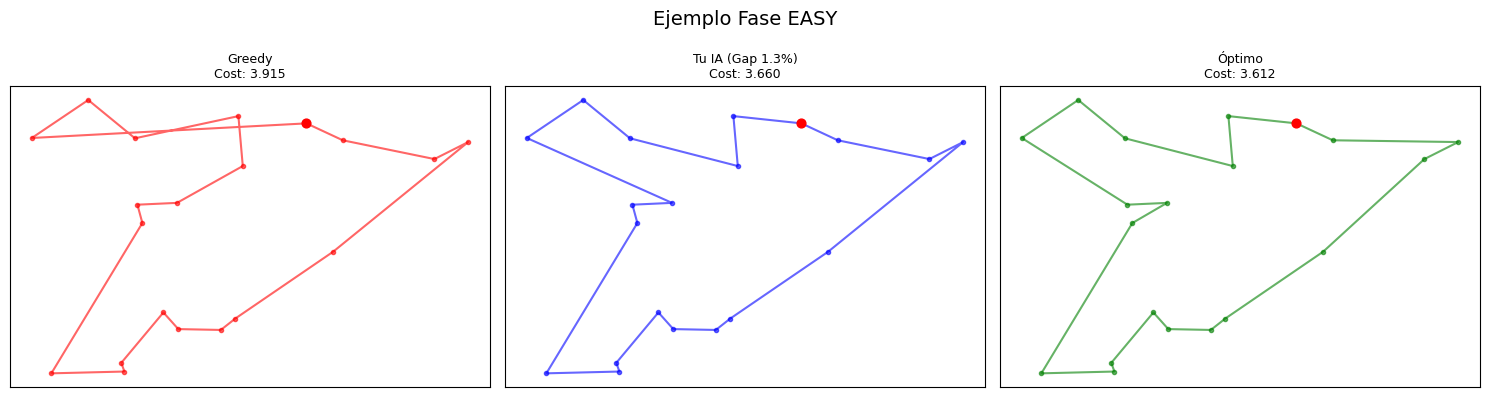


🔹 FASE: MEDIUM
   🐢 Ejecutando Greedy...
   🧠 Ejecutando IA (Beam Search)...


100%|██████████| 8/8 [00:01<00:00,  7.18it/s]


------------------------------
   📊 RESULTADOS (1000 casos):
   🔴 Gap Greedy: 21.27%
   🔵 Gap IA:     3.15%
   ✨ Mejora:     18.12 puntos porcentuales
------------------------------


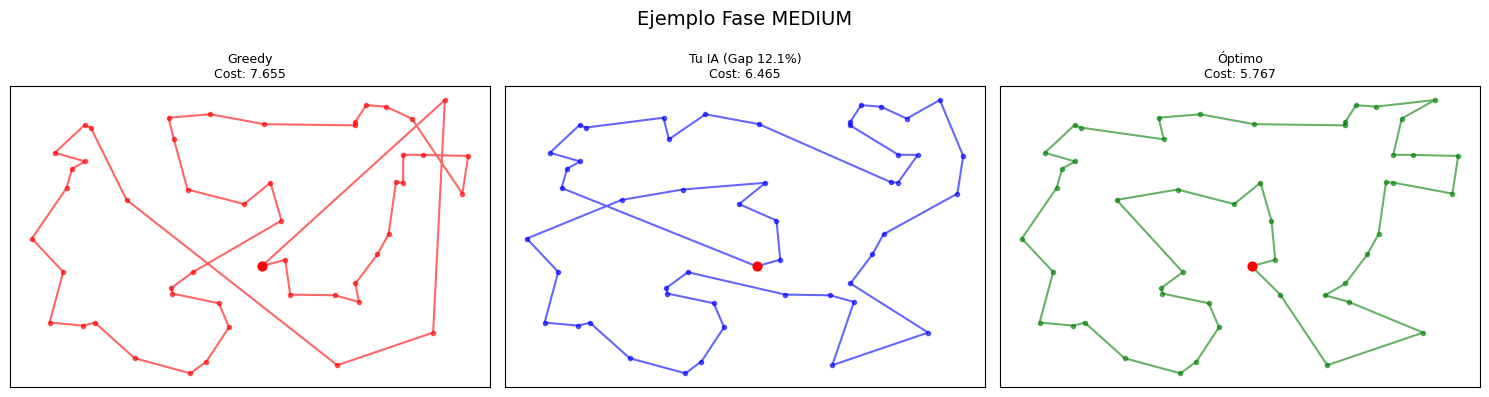


🔹 FASE: HARD
   🐢 Ejecutando Greedy...
   🧠 Ejecutando IA (Beam Search)...


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


------------------------------
   📊 RESULTADOS (500 casos):
   🔴 Gap Greedy: 21.17%
   🔵 Gap IA:     4.66%
   ✨ Mejora:     16.51 puntos porcentuales
------------------------------


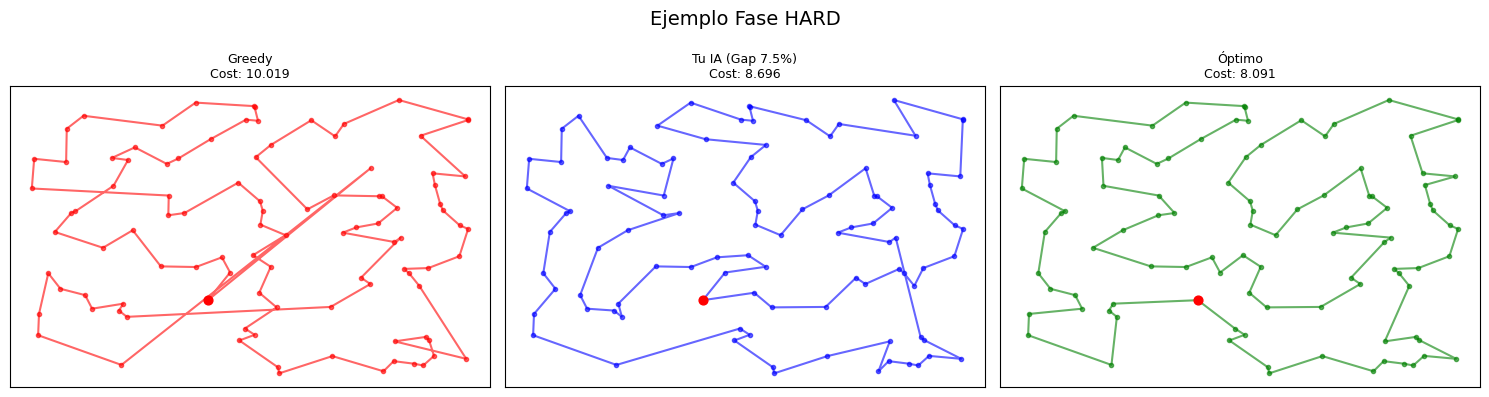

In [12]:
import requests
import os
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
REPO_USER = "felipe-astudillo-s"
REPO_NAME = "TransformerTSP"
BRANCH = "main"
VAL_FOLDERS = {
    "EASY":   {"gh_path": "Data/Validation/Easy",   "prefix": "tsp_easy"},   # 20 ciudades
    "MEDIUM": {"gh_path": "Data/Validation/Medium", "prefix": "tsp_medium"}, # 50 ciudades
    "HARD":   {"gh_path": "Data/Validation/Hard",   "prefix": "tsp_hard"}    # 100 ciudades
}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEAM_WIDTH = 1  # Greedy
BATCH_SIZE = 128

# ---------------------------------------------------------
# 1. GESTIÓN DE DATOS (DESCARGA Y CARGA)
# ---------------------------------------------------------
GLOBAL_DATA = {}

def download_and_load_github_data():
    print("📦 Iniciando descarga y carga de datos desde GitHub...")

    for phase, cfg in VAL_FOLDERS.items():
        print(f"   🔹 Procesando Fase: {phase}...")
        local_dir = f"val_data/{phase}"
        os.makedirs(local_dir, exist_ok=True)

        # A. Listar archivos via API
        api_url = f"https://api.github.com/repos/{REPO_USER}/{REPO_NAME}/contents/{cfg['gh_path']}?ref={BRANCH}"
        try:
            resp = requests.get(api_url)
            if resp.status_code != 200:
                print(f"      ⚠️ Error API GitHub: {resp.status_code}"); continue
            files = resp.json()
        except: print("      ⚠️ Error de conexión."); continue

        all_points, all_sols = [], []
        count = 0

        # B. Descargar y Procesar .npz
        for item in files:
            if item['name'].endswith('.npz') and item['name'].startswith(cfg['prefix']):
                local_path = os.path.join(local_dir, item['name'])

                # Descargar si no existe
                if not os.path.exists(local_path):
                    with open(local_path, 'wb') as f:
                        f.write(requests.get(item['download_url']).content)

                # Cargar
                try:
                    data = np.load(local_path, allow_pickle=True)
                    pts = data['points'] # [B, N, 2]
                    sols = data['solutions'] # [B, N]

                    # Normalizar formato de soluciones
                    if sols.dtype == np.object_:
                        sols = np.vstack(sols).astype(np.int64)
                    else:
                        sols = sols.astype(np.int64)

                    all_points.append(pts)
                    all_sols.append(sols)
                    count += 1
                except Exception as e:
                    print(f"      ❌ Error leyendo {item['name']}: {e}")

        if all_points:
            # Concatenar todo
            X_concat = np.concatenate(all_points)
            Y_concat = np.concatenate(all_sols)

            GLOBAL_DATA[phase] = {'X': X_concat, 'Y': Y_concat}
            print(f"      ✅ {count} archivos cargados. Total casos: {len(X_concat)}")
        else:
            print("      ⚠️ No se encontraron datos válidos.")

    print("\n✨ Datos listos en memoria.")

# ---------------------------------------------------------
# 2. SOLVERS (IA & GREEDY)
# ---------------------------------------------------------

def solve_greedy_batch(x):
    """Greedy Nearest Neighbor vectorizado"""
    B, N, _ = x.shape
    device = x.device
    dists = torch.cdist(x, x, p=2)
    dists.diagonal(dim1=-2, dim2=-1).fill_(float('inf'))

    current_city = torch.zeros(B, dtype=torch.long, device=device)
    tour = [current_city]
    visited_mask = torch.zeros(B, N, dtype=torch.bool, device=device)
    batch_indices = torch.arange(B, device=device)
    visited_mask[batch_indices, current_city] = True

    for _ in range(N - 1):
        d_curr = dists[batch_indices, current_city]
        d_curr[visited_mask] = float('inf')
        next_city = d_curr.argmin(dim=1)
        current_city = next_city
        visited_mask[batch_indices, current_city] = True
        tour.append(current_city)

    return torch.stack(tour, dim=1)



# ---------------------------------------------------------
# 3. HELPERS Y PLOTTING
# ---------------------------------------------------------

def calc_dist(points, tour_idx):
    """Calcula distancia total del tour (batch)"""
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    # Gather ordena los puntos según el tour
    ordered = points.gather(1, tour_idx.unsqueeze(-1).expand(-1, -1, 2))
    # Distancia entre puntos consecutivos + vuelta al inicio
    diff = ordered - torch.roll(ordered, -1, dims=1)
    return torch.norm(diff, dim=2).sum(dim=1)

def plot_case(ax, points, tour, cost, title, color):
    # Tour cerrado para dibujar
    tour = list(tour) + [tour[0]]
    path = points[tour]
    ax.plot(path[:,0], path[:,1], 'o-', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0,0], path[0,1], c='red', s=40, zorder=10) # Inicio
    ax.set_title(f"{title}\nCost: {cost:.3f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

# ---------------------------------------------------------
# 4. EJECUCIÓN PRINCIPAL
# ---------------------------------------------------------

def run_external_validation():
    # 1. Cargar Datos
    if not GLOBAL_DATA:
        download_and_load_github_data()

    # 2. Cargar Modelo
    model_path = "models/CNN_TSP_Model.pth" # Asegúrate que este sea el nombre correcto
    if not os.path.exists(model_path):
        print(f"⚠️ No encuentro el modelo en {model_path}")
        # Intentamos con el nombre alternativo por si acaso
        model_path = "models/tsp_transformer.pth"
        if not os.path.exists(model_path): return

    print(f"🧠 Cargando modelo desde {model_path}...")

    # --- CORRECCIÓN AQUÍ ---
    # Debemos usar num_encoder_layers=2 y num_heads=4 para coincidir con tu entrenamiento
    model = TSPTransformer(
        input_dim=2,
        embed_dim=128,
        num_heads=4,          # Antes tenías 8
        num_encoder_layers=2, # Antes tenías 3 (Esto causaba el error)
        num_glimpses=2,       # Aseguramos que coincida también
        dropout_rate=0.1
    ).to(DEVICE)
    # -----------------------

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("✅ Pesos cargados correctamente.")
    except Exception as e:
        print(f"❌ Error crítico cargando pesos: {e}")
        print("💡 Consejo: Verifica que 'embed_dim', 'num_heads' y 'num_layers' sean IDÉNTICOS al entrenamiento.")
        return

    model.eval()

    print(f"🚀 INICIANDO EVALUACIÓN (Beam Width={BEAM_WIDTH})")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_np = data['X']
        Y_np = data['Y']

        n_samples = min(1000, len(X_np))
        X_eval = X_np[:n_samples]
        Y_eval = Y_np[:n_samples]

        X_tensor = torch.tensor(X_eval, dtype=torch.float32).to(DEVICE)

        # --- A. GREEDY BASELINE ---
        print("   🐢 Ejecutando Greedy...")
        tours_greedy = []
        for i in range(0, n_samples, BATCH_SIZE):
            batch = X_tensor[i:i+BATCH_SIZE]
            tours_greedy.append(solve_greedy_batch(batch))
        tours_greedy = torch.cat(tours_greedy)
        cost_greedy = calc_dist(X_tensor, tours_greedy)

        # --- B. TU MODELO (IA) ---
        print("   🧠 Ejecutando IA (Beam Search)...")
        tours_ai = []
        for i in tqdm(range(0, n_samples, BATCH_SIZE)):
            batch = X_tensor[i:i+BATCH_SIZE]
            tours_ai.append(solve_beam_batch(model, batch, beam_width=BEAM_WIDTH))
        tours_ai = torch.cat(tours_ai)
        cost_ai = calc_dist(X_tensor, tours_ai)

        # --- C. ÓPTIMO ---
        Y_tensor = torch.tensor(Y_eval, dtype=torch.long).to(DEVICE)
        Y_clean = Y_tensor.clone()
        Y_clean[Y_clean == -1] = 0
        cost_opt = calc_dist(X_tensor, Y_clean)

        # --- MÉTRICAS ---
        # Evitar división por cero si el costo óptimo es 0 (caso trivial)
        mask = cost_opt > 0
        gap_ai = torch.zeros_like(cost_ai)
        gap_greedy = torch.zeros_like(cost_greedy)

        gap_ai[mask] = ((cost_ai[mask] - cost_opt[mask]) / cost_opt[mask]) * 100
        gap_greedy[mask] = ((cost_greedy[mask] - cost_opt[mask]) / cost_opt[mask]) * 100

        avg_gap_ai = gap_ai.mean().item()
        avg_gap_gr = gap_greedy.mean().item()

        improvement = avg_gap_gr - avg_gap_ai

        print("-" * 30)
        print(f"   📊 RESULTADOS ({n_samples} casos):")
        print(f"   🔴 Gap Greedy: {avg_gap_gr:.2f}%")
        print(f"   🔵 Gap IA:     {avg_gap_ai:.2f}%")
        print(f"   ✨ Mejora:     {improvement:.2f} puntos porcentuales")
        print("-" * 30)

        # --- VISUALIZACIÓN ---
        idx = 0
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        plot_case(axs[0], X_eval[idx], tours_greedy[idx].cpu(), cost_greedy[idx].item(), "Greedy", "red")
        plot_case(axs[1], X_eval[idx], tours_ai[idx].cpu(), cost_ai[idx].item(), f"Tu IA (Gap {gap_ai[idx].item():.1f}%)", "blue")
        plot_case(axs[2], X_eval[idx], Y_eval[idx], cost_opt[idx].item(), "Óptimo", "green")
        plt.suptitle(f"Ejemplo Fase {phase}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Ejecutar el bloque completo
run_external_validation()

# VALIDACIÓN PRO: TEST-TIME AUGMENTATION (TTA x8)

In [ ]:

def augment_batch_8x(x):
    """Genera 8 variaciones isométricas del batch de mapas."""
    # x: [B, N, 2]
    # 0. Original
    x0 = x.clone()
    # 1. Rot 90
    x1 = torch.stack([x[:,:,1], 1-x[:,:,0]], dim=2)
    # 2. Rot 180
    x2 = torch.stack([1-x[:,:,0], 1-x[:,:,1]], dim=2)
    # 3. Rot 270
    x3 = torch.stack([1-x[:,:,1], x[:,:,0]], dim=2)
    # 4. Flip X
    x4 = torch.stack([1-x[:,:,0], x[:,:,1]], dim=2)
    # 5. Flip X + Rot 90
    x5 = torch.stack([x[:,:,1], x[:,:,0]], dim=2) # Transpose
    # 6. Flip X + Rot 180
    x6 = torch.stack([x[:,:,0], 1-x[:,:,1]], dim=2)
    # 7. Flip X + Rot 270
    x7 = torch.stack([1-x[:,:,1], 1-x[:,:,0]], dim=2)

    # Retorna shape [B*8, N, 2]
    return torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], dim=0)

def solve_tta(model, x_batch):
    """Resuelve usando TTA x8 y devuelve la mejor distancia por instancia."""
    B, N, _ = x_batch.shape

    # 1. Expandir el batch x8 (Augmentation)
    x_aug = augment_batch_8x(x_batch) # [B*8, N, 2]

    # 2. Resolver todo el batch aumentado
    with torch.no_grad():
        # Encode una vez para todo el batch aumentado
        memory = model.encode(x_aug)

        # Greedy Decoding manual
        tours = torch.zeros((B*8, N), dtype=torch.long).to(DEVICE)
        visited = torch.full((B*8, N), -1, dtype=torch.long).to(DEVICE)
        visited[:, 0] = 0

        for t in range(N - 1):
            logits = model.decode(memory, x_aug, visited)
            next_city = logits.argmax(dim=1)
            tours[:, t+1] = next_city
            visited[:, t+1] = next_city

    # 3. Calcular distancias de las 8 versiones
    dists = calc_dist(x_aug, tours) # [B*8]

    # 4. Volver a agrupar [B, 8] y tomar el mínimo
    dists = dists.view(8, B).transpose(0, 1) # [B, 8]
    best_dists, _ = dists.min(dim=1) # [B]

    return best_dists

def run_tta_validation():
    print(f"🚀 INICIANDO VALIDACIÓN TTA (x8) - La prueba definitiva")

    # 1. Cargar Datos si no están
    if not GLOBAL_DATA: download_and_load_github_data()

    # 2. CARGAR MODELO (Robust Load)
    model_path = "models/tsp_transformer_ep3.pth"
    if not os.path.exists(model_path):
        model_path = "models/tsp_transformer.pth" # Intento alternativo

    if not os.path.exists(model_path):
        print(f"❌ Error: No encuentro el modelo en 'models/'.")
        return

    print(f"🧠 Cargando modelo desde: {model_path}")

    # Instanciar con la arquitectura CORRECTA (2 capas, 4 heads)
    model = TSPTransformer(
        input_dim=2,
        embed_dim=128,
        num_heads=4,          # Configuración del entrenamiento
        num_encoder_layers=2, # Configuración del entrenamiento
        num_glimpses=2,
        dropout_rate=0.1
    ).to(DEVICE)

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("✅ Pesos cargados correctamente.")
    except Exception as e:
        print(f"❌ Error cargando pesos: {e}")
        return

    model.eval()

    # 3. BUCLE DE VALIDACIÓN
    for phase, data in GLOBAL_DATA.items():
        X_np = data['X']
        Y_np = data['Y']

        # Usamos menos muestras para TTA porque es 8 veces más pesado
        n_samples = min(200, len(X_np))
        X_eval = torch.tensor(X_np[:n_samples], dtype=torch.float32).to(DEVICE)
        Y_eval = torch.tensor(Y_np[:n_samples], dtype=torch.long).to(DEVICE)

        # Calcular óptimo
        Y_clean = Y_eval.clone()
        Y_clean[Y_clean == -1] = 0
        cost_opt = calc_dist(X_eval, Y_clean)

        # Calcular IA con TTA
        cost_ai_tta = []
        batch_size = 16 # Batch más pequeño porque x8 ocupa memoria

        for i in tqdm(range(0, n_samples, batch_size), desc=f"Fase {phase}"):
            batch = X_eval[i:i+batch_size]
            dists = solve_tta(model, batch)
            cost_ai_tta.append(dists)

        cost_ai_tta = torch.cat(cost_ai_tta)

        # Gap
        # Evitar división por cero si cost_opt es 0 (caso trivial 1 ciudad)
        mask = cost_opt > 0
        gap = torch.zeros_like(cost_ai_tta)
        gap[mask] = ((cost_ai_tta[mask] - cost_opt[mask]) / cost_opt[mask]) * 100

        avg_gap = gap.mean().item()

        print(f"📊 {phase} (TTA x8): Gap Promedio = {avg_gap:.2f}%")

# ¡Pruébalo!
run_tta_validation()

🚀 INICIANDO VALIDACIÓN TTA (x8) - La prueba definitiva
❌ Error: No encuentro el modelo en 'models/'.


#Sampling

In [ ]:
# ==========================================
# VALIDACIÓN PRO: MULTI-SAMPLE (x128)
# ==========================================



def run_sampling_validation():
    print(f"🚀 INICIANDO VALIDACIÓN POR SAMPLING (x128)")

    # Parámetros
    SAMPLES_PER_MAP = 10
    TEMP = 1.0 # Temperatura estándar

    if not GLOBAL_DATA: download_and_load_github_data()

    # Cargar Modelo (Asegúrate que la ruta sea la correcta)
    model_path = "models/tsp_transformer_ep3.pth"
    model = TSPTransformer(input_dim=2, embed_dim=128, num_heads=4, num_encoder_layers=2).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    for phase, data in GLOBAL_DATA.items():
        X_np = data['X']
        Y_np = data['Y']

        n_samples = min(100, len(X_np)) # Reducimos N de test porque Sampling es pesado
        X_eval = torch.tensor(X_np[:n_samples], dtype=torch.float32).to(DEVICE)
        Y_eval = torch.tensor(Y_np[:n_samples], dtype=torch.long).to(DEVICE)

        # Óptimo
        Y_clean = Y_eval.clone()
        Y_clean[Y_clean == -1] = 0
        cost_opt = calc_dist(X_eval, Y_clean)

        # IA con Sampling
        cost_ai_sampling = []
        batch_size = 4 # Batch pequeño porque B * 128 consume mucha VRAM

        for i in tqdm(range(0, n_samples, batch_size), desc=f"Sampling {phase}"):
            batch = X_eval[i:i+batch_size]
            best_dists = solve_sampling(model, batch, num_samples=SAMPLES_PER_MAP, temperature=TEMP)
            cost_ai_sampling.append(best_dists)

        cost_ai_sampling = torch.cat(cost_ai_sampling)

        # Gap
        mask = cost_opt > 0
        gap = ((cost_ai_sampling[mask] - cost_opt[mask]) / cost_opt[mask]) * 100
        print(f"📊 {phase} (Sampling x128): Gap Promedio = {gap.mean().item():.2f}%")

run_sampling_validation()

🚀 INICIANDO VALIDACIÓN POR SAMPLING (x128)


Sampling EASY:   0%|          | 0/25 [00:00<?, ?it/s]


NameError: name 'solve_sampling' is not defined